<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/kl.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(kl_notebook)=
# La divergenza di Kullback-Leibler

Nel campo della statistica e del machine learning, ci si trova spesso di fronte alla necessità di utilizzare una distribuzione di probabilità, che indichiamo con $ q $, come approssimazione di un'altra distribuzione più complessa o sconosciuta, indicata con $ p $. Questa necessità emerge in modo particolare quando trattare direttamente con la distribuzione $ p $ risulta impraticabile a causa della sua complessità o dell'incertezza sulle sue caratteristiche. Di conseguenza, emerge una domanda fondamentale: quanta informazione perdiamo utilizzando la distribuzione $ q $ in luogo di $ p $, e come questa scelta influisce sull'incertezza nei nostri risultati analitici?

Per rispondere a queste domande, ci affidiamo a un indicatore chiave noto come *Divergenza di Kullback-Leibler* (KL), introdotto nel capitolo precedente. Questa metrica, denotata come $ \mathbb{KL}(p \mid\mid q) $, misura la discrepanza tra le due distribuzioni di probabilità. Un valore di zero indica che le distribuzioni $ q $ e $ p $ sono identiche, mentre valori maggiori di zero riflettono discrepanze crescenti tra le due. In questo senso, la Divergenza KL funge da misura quantitativa per valutare la "vicinanza" o somiglianza tra distribuzioni.

Parallelamente, l'*Expected Log Predictive Density* (elpd) rappresenta un altro strumento fondamentale nell'ambito della valutazione dei modelli statistici. Questa misura valuta l'adeguatezza di un modello statistico rispetto ai dati osservati, fornendo un equilibrio tra la capacità del modello di adattarsi ai dati e la sua complessità. L'elpd si rivela particolarmente efficace nel confrontare diversi modelli statistici, offrendo uno strumento per bilanciare adattamento e complessità.

Il focus di questo capitolo sarà dunque su queste due metriche fondamentali: la Divergenza di Kullback-Leibler e l'elpd. Approfondiremo la loro rilevanza nella valutazione e nel confronto di modelli statistici, con un'attenzione particolare al contesto bayesiano. Con una conoscenza approfondita di questi strumenti, il lettore sarà in grado di applicare efficacemente queste misure nella selezione e nell'analisi di modelli statistici, adeguandoli a specifici set di dati.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Perdita di Informazione e Divergenza di Kullback-Leibler

La *Divergenza di Kullback-Leibler* (KL), conosciuta anche come entropia relativa, è uno strumento statistico fondamentale per quantificare la quantità di informazione che si "perde" quando una distribuzione di probabilità vera, indicata con $ p $, viene sostituita da una distribuzione approssimata, $ q $. Matematicamente, la Divergenza KL si definisce come l'aspettativa del logaritmo del rapporto tra le distribuzioni $ p $ e $ q $, ponderata secondo la distribuzione vera $ p $. La sua formula è la seguente:

$$
\mathbb{KL} (p \mid\mid q) = \sum_i^n p_i (\log p_i - \log q_i),
$$

dove l'indice $i$ si estende a tutti gli elementi possibili nelle distribuzioni. Questa misura ci offre una valutazione della discrepanza media nelle probabilità logaritmiche quando $ q $ viene usata per approssimare $ p $.

La Divergenza di Kullback-Leibler può essere anche vista in termini di entropia, ossia come la differenza tra l'entropia incrociata, denotata con $ h(p, q) $, e l'entropia della distribuzione vera, $ h(p) $. Le formule per queste due misure di entropia sono:

$$
\begin{align*}
h(p) & = -\sum_i^n p_i \log p_i, \\
h(p, q) & = -\sum_i^n p_i \log q_i.
\end{align*}
$$

In questo contesto, $ h(p) $ rappresenta l'incertezza intrinseca associata alla distribuzione vera $ p $, mentre $ h(p, q) $ indica l'incertezza che deriva dall'utilizzo delle probabilità logaritmiche di $ q $, calcolate però usando le probabilità di $ p $.

Di conseguenza, la formula della Divergenza KL può essere riformulata come:

$$
\mathbb{KL} (p \mid\mid q) = h(p, q) - h(p).
$$

In sintesi, la Divergenza KL ci permette di misurare la differenza di incertezza tra l'uso di $ q $ come approssimazione di $ p $ e l'incertezza originale di $ p $. È un indicatore cruciale di quanto accuratamente $ q $ riesca a approssimare $ p $, quantificando la perdita di informazione associata a questa approssimazione.

### Un Esempio Empirico

Per comprendere meglio questi concetti, esaminiamo ora un esempio pratico in Python, dove definiremo due distribuzioni di probabilità discrete, $p$ e $q$.

In [3]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.6, 0.3])

Calcoliamo l'entropia di $p$.

In [4]:
h_p = -np.sum(p * np.log2(p))
print("Entropia di p: ", h_p)

Entropia di p:  1.4854752972273344


Calcoliamo l'entropia incrociata tra $p$ e $q$.

In [5]:
h_pq = -np.sum(p * np.log2(q))
print("Entropia incrociata tra p e q: ", h_pq)

Entropia incrociata tra p e q:  1.5539580943104374


Calcoliamo la divergenza di Kullback-Leibler da $p$ a $q$.

In [6]:
kl_pq = h_pq - h_p
print("Divergenza KL da p a q: ", kl_pq)

Divergenza KL da p a q:  0.06848279708310301


Consideriamo un secondo esempio. Sia $p$ una distribuzione binomiale di parametri $\theta = 0.2$ e $n = 5$.

In [6]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


Sia $q_1$ una approssimazione a $p$:

In [7]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


Sia $q_2$ una distribuzione uniforme:

In [8]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


La divergenza $\mathbb{KL}$ di $q_1$ da $p$ è

In [12]:
kl_pq1 = np.sum(true_py * np.log(true_py / q1))
print("Divergenza KL da p a q1: ", kl_pq1)

Divergenza KL da p a q1:  0.029251990333458988


La divergenza $\mathbb{KL}$ di $q_2$ da $p$ è:

In [13]:
kl_pq2 = np.sum(true_py * np.log(true_py / q2))
print("Divergenza KL da p a q2: ", kl_pq2)

Divergenza KL da p a q2:  0.4863577787141544


È chiaro che perdiamo una quantità maggiore di informazioni se, per descrivere la distribuzione binomiale $p$, usiamo la distribuzione uniforme $q_2$ anziché $q_1$.

### La divergenza dipende dalla direzione

La divergenza di Kullback-Leibler ($ \mathbb{KL} $) non è simmetrica, il che significa che $ \mathbb{KL}(p \mid\mid q) \neq \mathbb{KL}(q \mid\mid p) $. Illustriamo numericamente questo concetto per due distribuzioni $p = \{0.01, 0.99\}$ e $q = \{0.7, 0.3\}$.

In [14]:
# Definire le distribuzioni p e q
p = np.array([0.01, 0.99])
q = np.array([0.7, 0.3])

# Calcolo dell'entropia di p
h_p = -np.sum(p * np.log(p))

# Calcolo dell'entropia incrociata da p a q
h_pq = -np.sum(p * np.log(q))

# Calcolo della divergenza KL da p a q
kl_pq = h_pq - h_p

# Calcolo dell'entropia di q
h_q = -np.sum(q * np.log(q))

# Calcolo dell'entropia incrociata da q a p
h_qp = -np.sum(q * np.log(p))

# Calcolo della divergenza KL da q a p
kl_qp = h_qp - h_q

print(f"Entropia di p: {h_p}")
print(f"Entropia incrociata da p a q: {h_pq}")
print(f"Divergenza KL da p a q: {kl_pq}")

print(f"\nEntropia di q: {h_q}")
print(f"Entropia incrociata da q a p: {h_qp}")
print(f"Divergenza KL da q a p: {kl_qp}")

Entropia di p: 0.056001534354847345
Entropia incrociata da p a q: 1.1954998257220641
Divergenza KL da p a q: 1.1394982913672167

Entropia di q: 0.6108643020548935
Entropia incrociata da q a p: 3.226634230947714
Divergenza KL da q a p: 2.6157699288928207


## Confronto tra modelli tramite la divergenza $\mathbb{KL}$

La divergenza $\mathbb{KL}$ è uno strumento utilizzato per confrontare diversi modelli probabilistici. Essa quantifica la discrepanza tra la distribuzione di probabilità generata da un modello ipotetico $p_{\mathcal{M}}$ e quella del modello che effettivamente ha generato i dati, $p_t$.

### Distribuzione predittiva a posteriori

Abbiamo precedentemente introdotto il concetto di distribuzione predittiva a posteriori, formulata come segue:

$$
p(\tilde{y} \mid y) = \int_\Theta p(\tilde{y} \mid \theta) p(\theta \mid y) \, \mathrm{d}\theta .
$$

Questa distribuzione riflette il tipo di dati che ci aspettiamo siano generati dal modello $\mathcal{M}$, considerando sia le nostre credenze a priori $p(\theta)$ sia i dati effettivamente osservati $y$.

### Valutazione della somiglianza tra distribuzioni

L'obiettivo è di valutare quanto bene la distribuzione $q_{\mathcal{M}} = p(\tilde{y} \mid y)$ approssimi la distribuzione del modello generatore reale $p_t(\tilde{y})$. In altre parole, vogliamo quantificare quanto siano "simili" i dati generati dal modello ipotetico $q_{\mathcal{M}}$ rispetto a quelli generati dal modello reale $p_t$. La misura di questa somiglianza è fornita dalla divergenza di Kullback-Leibler:

$$
\mathbb{KL}(p_t \mid\mid q_{\mathcal{M}}).
$$

### Confronto tra modelli multipli

Immaginiamo di avere $k$ modelli distinti $ \{q_{\mathcal{M}_1}, q_{\mathcal{M}_2}, \ldots, q_{\mathcal{M}_k}\} $. Se conoscessimo $p_t$, potremmo calcolare la divergenza di Kullback-Leibler per ogni modello come segue:

$$
\begin{align*}
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_1}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_1}) \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_2}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_2}) \\
&\vdots \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_k}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_k}) .
\end{align*}
$$ (eq-kl-mod-comp)

Anche se nella pratica $p_t$ è sconosciuta, notiamo che essa è costante in tutti i termini della divergenza. Di conseguenza, possiamo confrontare i modelli focalizzandoci sul secondo termine della divergenza di Kullback-Leibler, che è indipendente da $p_t$. Per un modello generico $\mathcal{M}$, questo termine può essere espresso come:

$$
\mathbb{E} \log p_{\mathcal{M}}(y) = \int_{-\infty}^{+\infty} p_{t}(y) \log p_{\mathcal{M}}(y) \, \mathrm{d}y .
$$ (eq-kl-div-cont-t2)

In questo modo, siamo in grado di costruire un criterio di confronto tra modelli che non richiede la conoscenza del modello generatore reale dei dati.

In conclusione, l'eq. {eq}`eq-kl-div-cont-t2` esprime la densità logaritmica media della distribuzione $p_{\mathcal{M}}(y)$ secondo la distribuzione vera $p_t(y)$. In altre parole, questa equazione ci dice quanto bene il modello $\mathcal{M}$ può rappresentare i dati veri generati da $p_t$.

## Expected Log Predictive Density

Dopo aver discusso l'equazione {eq}`eq-kl-div-cont-t2`, possiamo riformularla come segue:

$$
\begin{equation}
elpd = \int_{\tilde{y}} p_{t}(\tilde{y}) \log p(\tilde{y} \mid y) \, \mathrm{d}\tilde{y} .
\end{equation}
$$ (eq-elpd)

L'equazione {eq}`eq-elpd` è conosciuta come *Expected Log Predictive Density* (elpd). Esaminiamo con attenzione le differenze tra la elpd e l'eq. {eq}`eq-kl-div-cont-t2`.

1. **Variabile di Interesse**: Nell'eq. {eq}`eq-kl-div-cont-t2`, $y$ rappresenta i dati osservati. Nell'eq. {eq}`eq-elpd`, invece, $\tilde{y}$ rappresenta potenziali nuovi dati che potrebbero essere osservati in futuro.

2. **Modello di Probabilità**: Nell'eq. {eq}`eq-kl-div-cont-t2`, $p_{\mathcal{M}}(y) $ rappresenta il modello probabilitico basato sui dati osservati. Nell'eq. {eq}`eq-elpd`, invece, $p(\tilde{y} \mid y)$ è la distribuzione predittiva a posteriori, che rappresenta le previsioni del modello per nuovi dati, date le osservazioni precedenti $y$.

3. **Ruolo di $p_t$**: In entrambe le formule, $p_t$ rappresenta la "vera" distribuzione dei dati. Nella prima formula, essa valuta quanto accuratamente il modello rappresenta i dati effettivamente osservati, mentre nella seconda pesa la qualità delle previsioni del modello per nuovi dati.

Quindi, mentre l'eq. {eq}`eq-kl-div-cont-t2` fornisce una misura di quanto bene il modello si adatta ai dati osservati, l'eq. {eq}`eq-elpd` valuta la probabilità che il modello effettui predizioni accurate su nuovi dati. Entrambe le formule sono collegate al concetto di divergenza $\mathbb{KL}$, ma sono applicate in contesti diversi: la prima per la valutazione del fit del modello, la seconda per la sua capacità predittiva.

### Approssimazione e stima

Non è necessario trovare una formulazione analitica esatta per $p(\tilde{y} \mid y)$, in quanto è possibile approssimare questa distribuzione attraverso simulazioni. Tuttavia, è importante notare che l'eq. {eq}`eq-elpd` include il termine $p_t(\tilde{y})$, che rappresenta la distribuzione dei potenziali dati futuri secondo il "vero" modello generatore. Poiché $p_t$ è in pratica ignoto, l'elpd non può essere calcolata esattamente ma può solo essere stimata. Il prossimo punto di discussione in questo capitolo riguarderà le strategie per stimare efficacemente l'elpd utilizzando un campione di osservazioni.

### Un esempio pratico

Esaminiamo un esempio tratto da [Bayesian Data Analysis for Cognitive Science](https://vasishth.github.io/bayescogsci/book/expected-log-predictive-density-of-a-model.html) nel quale la elpd viene calcolata in forma esatta oppure mediante approssimazione. Supponiamo di disporre di un campione di $n$ osservazioni. Supponiamo inoltre di conoscere il vero processo generativo dei dati (qualcosa che in pratica non è mai possibile), ovvero:

$$
p_t(y) = Beta(1, 3).
$$ 

I dati sono

In [10]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]


Supponiamo inoltre di avere adattato ai dati un modello bayesiano $\mathcal{M}$ e di avere ottenuto la distribuzione a posteriori per i parametri del modello. Inoltre, supponiamo di avere derivato la forma analitica della distribuzione predittiva a posteriori per il modello:

$$
p(y^{rep} \mid y) \sim Beta(2, 2).
$$

Questa distribuzione ci dice quanto sono credibili i possibili dati futuri.

Conoscendo la vera distribuzione dei dati $p_t(y)$ possiamo calcolare in forma esatta la quantità $\text{ELPD}$, ovvero

$$
\text{ELPD} = \int_{y^{rep}}p_{t}(y^{rep})\log p(y^{rep} \mid y) \,\operatorname {d}\!y^{rep}.
$$

Svolgiamo i calcoli otteniamo:

In [11]:
# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)
print(error)

-0.3749071974384449
3.0236368964153826e-12


Tuttavia, in pratica non conosciamo mai $p_t(y)$. Quindi approssimiamo $\text{ELPD}$ usando l'eq. {eq}`eq-elpd`:

$$
\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid y).
$$ (eq-empirical-elpd)

L'espressione {eq}`eq-empirical-elpd` è una forma empirica della $\text{ELPD}$, utilizzata quando abbiamo a disposizione un campione di dati osservati $\{y_1, y_2, \ldots, y_n\}$ per approssimare l'integrazione in $\text{ELPD}$. Mentre la definizione più generale di $\text{ELPD}$ è un'integrazione su tutte le possibili realizzazioni future $\tilde{y}$ pesate dalla loro probabilità "vera" $p_t(\tilde{y})$, in pratica potremmo non avere accesso a questa distribuzione vera $p_t$. 

In questo caso, utilizziamo il nostro campione osservato come un'approssimazione empirica della distribuzione vera. In altre parole, stiamo utilizzando i dati osservati come un set rappresentativo di "possibili futuri dati". Questo è fondamentalmente un'approssimazione Monte Carlo della $\text{ELPD}$, che si basa sul principio che, data una quantità sufficiente di dati, la media campionaria può approssimare l'integrazione prevista.

La formula $\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid y)$ si concentra sul calcolo del logaritmo della densità predittiva a posteriori $p(y_i \mid y) $ per ogni punto dati osservato $y_i$ e poi prende la media aritmetica. Se $n$ è grande e il campione è rappresentativo, questa media aritmetica dovrebbe avvicinarsi all'$\text{ELPD}$ vero e proprio, definito come $\int_{\tilde{y}} p_{t}(\tilde{y}) \log p(\tilde{y} \mid y) \, \mathrm{d}\tilde{y}.$ Tuttavia, è importante sottolineare che questa è un'approssimazione e può essere imprecisa se la dimensione del campione è piccola o se i dati osservati non sono una buona rappresentazione della distribuzione "vera" $p_t$.

Nel caso dell'esempio in discussione, usando l'eq. {eq}`eq-empirical-elpd` otteniamo un valore approssimato a quello trovato in precedenza:

In [16]:
1 / n * np.sum(np.log(p(y_data)))

-0.3721938430299501

La formula empirica {eq}`eq-empirical-elpd` è frequentemente utilizzata per approssimare la ELPD in applicazioni pratiche. In sostanza, attraverso l'ELPD, miriamo a valutare la capacità del nostro modello di effettuare previsioni affidabili su nuovi dati non ancora analizzati. Esaminiamo i vari elementi della formula:

1. **Densità logaritmica predittiva $ \log p(y_i \mid y) $ per un dato $ y_i $**: Si tratta di un indice che misura l'efficacia con cui il modello prevede un singolo dato $ y_i $, avendo a disposizione un set di dati $ y $. Valori più elevati di $ \log p(y_i \mid y) $ suggeriscono che il modello attribuisce una probabilità alta ai dati effettivamente osservati, segno che il modello è performante.

2. **Media della densità logaritmica predittiva**: Sommando i logaritmi delle densità predittive per ciascun punto del set di dati e dividendo per $ n $, otteniamo una media. Questo valore medio fornisce un'indicazione complessiva dell'efficacia predittiva del modello sull'intero set di dati. In questo caso, l'aspettativa (o media) è un'approssimazione basata sui dati a disposizione. Invece di calcolare l'integrale sotto la curva di densità per ogni possibile nuovo dato $ \tilde{y} $, utilizziamo i dati osservati $ y_1, y_2, \ldots, y_n $ come un surrogato empirico. Questa metodologia è una forma di approssimazione Monte Carlo.

Un alto valore di ELPD suggerisce che, in media, la densità predittiva del modello per i dati osservati è elevata. Dato che utilizziamo questi dati come approssimazione per futuri dati non ancora osservati, un alto ELPD è indicativo della probabile efficacia del modello nel prevedere nuovi dati.

In sintesi, l'ELPD serve come un indicatore globale della capacità del modello di effettuare previsioni accurate su dati non ancora osservati. Valori più alti sono sintomatici di un modello più efficace. È importante, tuttavia, tener presente che questa è una stima, calcolata in relazione al set di dati osservati; potrebbe quindi non essere un indicatore affidabile se i dati futuri differiscono significativamente da quelli osservati.

## Validazione incrociata Leave One Out (LOO)

Ma come si può ottenere in pratica il valore dell'ELPD? Se si ricorre a un metodo di stima MCMC, l'ELPD può essere approssimata mediante la *Leave One Out Cross-Validation* (LOO-CV). Con il metodo LOO, si rimuove un'osservazione dal campione, si adatta il modello ai dati rimanenti, e si verifica quanto bene esso predice l'osservazione esclusa. Si ripete questo processo per ogni osservazione nel set di dati, una per volta, e infine si calcola la media dei risultati per ottenere una stima LOO-CV. La validazione incrociata (Cross-Validation, CV) può essere vista come un metodo per stimare o approssimare metriche di performance fuori dal campione (out-of-sample), pur utilizzando l'intero dataset disponibile per l'addestramento e la valutazione. La libreria PyMC automatizza questo procedimento.

### Valori diagnostici Pareto $k$

Quanto affidabile è l'approssimazione effettuata attraverso LOO-CV? Per rispondere a questa domanda, si ricorre a un parametro diagnostico noto come valore Pareto $ k $.

Nel contesto della validazione incrociata di tipo Leave-One-Out (LOO), il valore Pareto $ k $ serve come un barometro per giudicare la precisione dell'approssimazione LOO. Il valore di $ k $ funge da indicatore della qualità dell'approssimazione e ha le seguenti interpretazioni:

- **$ k < 0.5 $**: In questo caso, l'approssimazione è generalmente ottima e l'errore associato è trascurabile.
  
- **$ 0.5 \leq k < 0.7 $**: L'approssimazione rimane buona, sebbene con qualche motivo di cautela. Un'analisi più approfondita del modello e dei dati potrebbe essere vantaggiosa.

- **$ 0.7 \leq k < 1 $**: La qualità dell'approssimazione è mediocre. I risultati derivanti da LOO possono essere poco affidabili; potrebbe quindi essere utile considerare metodi di validazione alternativi o apportare modifiche al modello.

- **$ k \geq 1 $**: Qui, l'approssimazione è inadeguata e i risultati da LOO sono molto probabilmente inaffidabili. Questo è un campanello d'allarme che indica potenziali problemi con il modello o con il metodo di approssimazione adottato.

Il valore diagnostico Pareto $ k $ è basato sulla distribuzione di Pareto e serve a valutare in che misura le code della distribuzione delle differenze di log-verosimiglianza (tra la log-verosimiglianza del punto dati escluso e quella relativa all'intero set di dati) divergono da una distribuzione esponenziale. Un valore di $ k $ elevato suggerisce che le code della distribuzione sono più pesanti del previsto, indicando che l'approssimazione LOO potrebbe essere imprecisa.

In sintesi, il valore Pareto $ k $ offre uno strumento pratico per verificare l'affidabilità dell'approssimazione LOO. Permette inoltre ai ricercatori di identificare e indagare su potenziali problematiche relative sia al modello che alla metodologia di validazione incrociata adottata.

### Ruolo dell'ELPD nella valutazione comparativa dei modelli

L'ELPD è una metrica essenziale per effettuare confronti tra vari modelli statistici. Ottenendo una stima dell'ELPD attraverso metodologie come la Validazione Incrociata Leave-One-Out (LOO-CV), si può acquisire una valutazione obiettiva dell'adeguatezza di ciascun modello rispetto ai dati a disposizione. Questo aspetto assume particolare importanza quando si è chiamati a selezionare il modello più idoneo tra diverse alternative, o quando si desidera determinare se un modello di maggiore complessità offra un migliore adattamento rispetto a uno più semplice.

In sintesi, l'ELPD funge da indicatore affidabile della capacità predittiva di un modello. Allo stesso tempo, la tecnica del LOO-CV fornisce un mezzo efficace per approssimare tale metrica. Grazie alla LOO-CV, gli analisti possono condurre una valutazione sia accurata che robusta delle prestazioni di differenti modelli, agevolando la decisione relativa al modello più appropriato per uno specifico contesto.

L'opportunità di automatizzare queste procedure di valutazione attraverso l'uso di librerie software come PyMC rende l'intero approccio ancor più accessibile e pratico, consolidando la sua utilità come strumento per l'accurata selezione e validazione di modelli statistici.

### Simulazione

Per illustrare questa metodologia di confronto tra modelli utilizzando la LOO-CV, procediamo con una simulazione. Genereremo dati sintetici in cui esiste una relazione lineare tra le variabili $x$ e $y$. In questo scenario, potremmo essere interessati a confrontare un modello lineare con un modello più semplice, che considera solo il termine di intercetta. Utilizzeremo la LOO-CV per stabilire quale dei due modelli si adatta meglio ai dati in questione. La stima dell'ELPD servirà come criterio quantitativo per orientare questa scelta di modello.

In [12]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [13]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [14]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:02.233419
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 516.83it/s]


Sampling time =  0:00:04.336943
Transforming variables...
Transformation time =  0:00:00.030114
Computing Log Likelihood...
Log Likelihood time =  0:00:00.477225


Adattiamo ora un secondo modello che non tiene conto della relazione lineare tra x e y.

In [15]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [16]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:00.668193
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 590.33it/s]


Sampling time =  0:00:03.502807
Transforming variables...
Transformation time =  0:00:00.008955
Computing Log Likelihood...
Log Likelihood time =  0:00:00.104065


Troviamo ora elpd con il metodo LOO.

In [17]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.52     6.90
p_loo        2.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2251.72   195.86
p_loo       41.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Infine, calcoliamo `eldp_diff`. L'incertezza di questa quantità è espressa dall'errore standard. Se il rapporto tra `eldp_diff` e il suo errore standard è almeno uguale a 2, allora possiamo concludere che vi è una differenza credibile tra di due modelli.

In [19]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.51541,2.803132,0.00000,1.000000e+00,6.899365,0.000000,False,log
intercept_model,1,-2251.72322,41.983400,2007.20781,2.519016e-10,195.858610,195.490666,False,log


Nel caso presente, sappiamo che il modello che include una relazione lineare tra le due variabili è quello che rispecchia il modo in cui i dati sono stati generati. Infatti, troviamo che il rapporto tra `eldp_diff` e il suo errore standard è molto maggiore di 2, il che conferma che, per questi dati, il modello lineare è da preferire al modello che include solo l'intercetta.

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


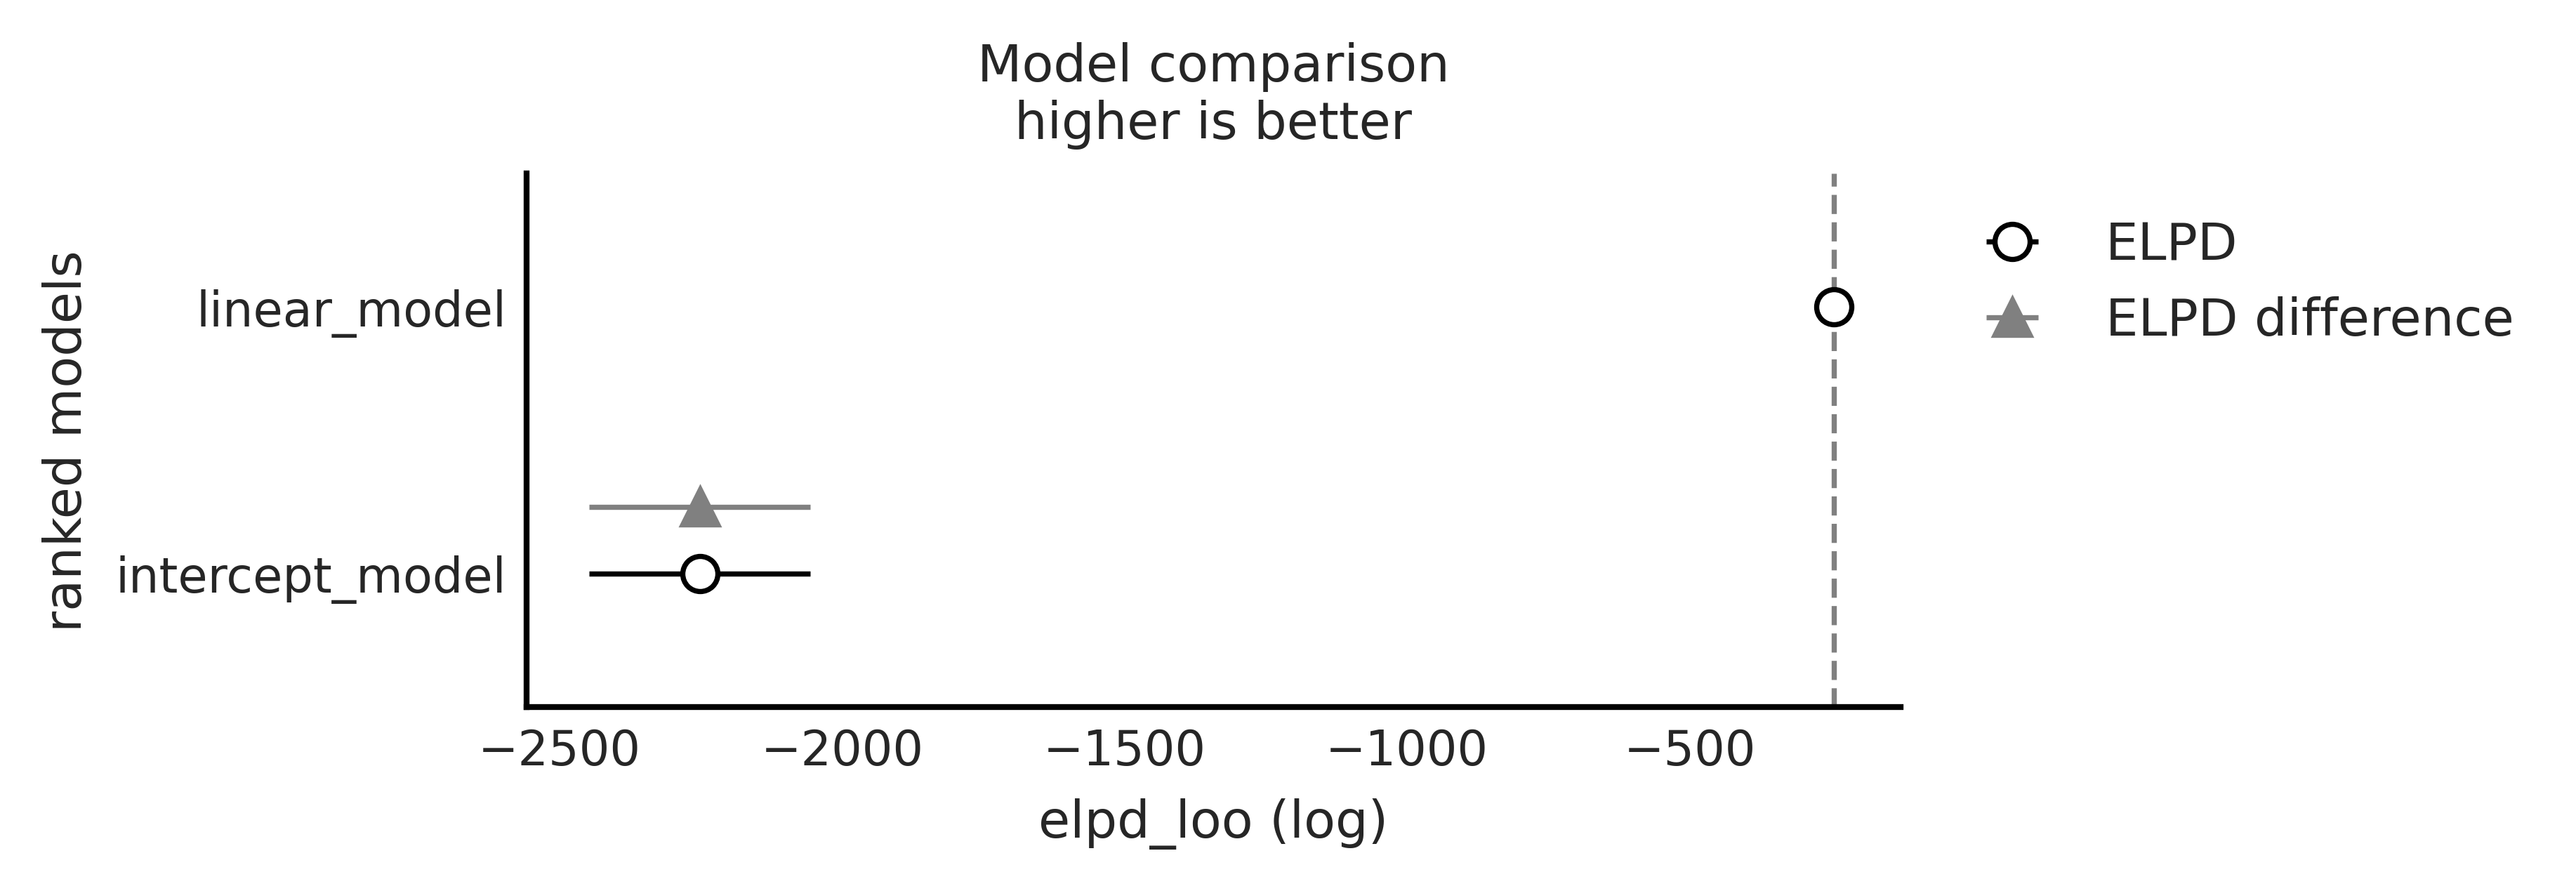

In [20]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Commenti e considerazioni finali 

Questo capitolo ha esplorato il ruolo fondamentale della Densità Logaritmica Predittiva Prevista (ELPD) nel campo della statistica applicata. L'ELPD non è solo una metrica per valutare le prestazioni di un singolo modello, ma serve anche come criterio per confrontare vari modelli tra loro.

Adottare l'ELPD come metrica per la comparazione di modelli fornisce un quadro oggettivo per stabilire quale modello si allinea meglio ai dati a nostra disposizione. In un ambiente di crescente complessità, dove le opzioni di modellazione sono numerose, l'ELPD diventa un criterio determinante per la selezione del modello più adatto. Che si tratti di confrontare un modello complesso con uno più semplice, o di scegliere tra modelli diversi, l'ELPD offre un orientamento affidabile e fondato sui dati.

In breve, l'ELPD è uno strumento utile nell'analisi dei dati moderna. Il suo utilizzo può rendere più chiare le decisioni su quale modello usare, contribuendo a risultati più affidabili e modelli più efficaci.

## Watermark

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 05 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

seaborn    : 0.12.2
statsmodels: 0.14.0
numpy      : 1.25.2
scipy      : 1.11.2
matplotlib : 3.7.2
arviz      : 0.16.1
pymc       : 5.7.2
pandas     : 2.1.0

Watermark: 2.4.3

